<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet fastai==2.2.5

In [3]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

Riferimento: https://stackoverflow.com/questions/30483246/how-to-check-if-a-python-module-has-been-imported

In [4]:
catboost = 'catboost'
if catboost not in sys.modules:
  !pip install catboost

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # serve per ignorare i FutureWarning

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)
# data, categorical_names = mf.encoding(data, 'cat_sign_col')

### Load

In [7]:
load = False
if load:
  model = CatBoostClassifier()
  model.load_model('catboost')  
  # model.load_model('catboost_class_weights')

### Train validation test split


In [8]:
X_train, X_val, y_train, y_val = mf.split(data, test_size = 0.2)
del data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [9]:
save_id = True 

if save_id:
  train_id = X_train.index.tolist()
  val_id = X_val.index.tolist()
  test_id = X_test.index.tolist()
  mf.save_list('train_id',train_id)
  mf.save_list('val_id', val_id)
  mf.save_list('test_id', test_id)

load_id = False 
if load_id:
  mf.load_list('train_id',train_id)
  mf.load_list('val_id', val_id)
  mf.load_list('test_id', test_id)

# Categorical Boost

Con 2000 iterazioni: AUC= 0.9, AP= 0.7

Con 4000 iterazioni: AUC= 0.92, AP= 0.73

Con class_weight: AUC = 0.91, AP = 0.68, F1 = 0.81, CM =  [[112057   1796]
 [  1459   2795]]

Non è stato fatto nè il one hot encoding nè l'easy ensemble.

Documentazione CatBoost: https://catboost.ai/docs/concepts/python-quickstart.html

Categorical features parameter: https://github.com/catboost/catboost/issues/934

gpu: https://catboost.ai/docs/features/training-on-gpu.html

Riferimento salvataggio del modello: https://stackoverflow.com/questions/51895761/how-to-correctly-load-pretrained-model-in-catboost-in-python

Riferimento class_weights: https://stackoverflow.com/questions/59746304/catboost-classifier-for-class-imbalance

In [ ]:
# cat_feature_list = np.arange(176,206)
# train_list = mf.to_list(X_train, cat_feature_list)

In [ ]:
cat_feature_list = []
for col in X_train.select_dtypes(include=['object']).columns:
  cat_feature_list.append(col)
cat_feature_list

In [20]:
from catboost import CatBoostClassifier#, Pool
model = CatBoostClassifier(iterations=3000, boosting_type='Plain', bootstrap_type='Bernoulli', 
                            subsample=0.5, border_count=32,
                            depth=10, learning_rate=1, task_type="GPU",
                            cat_features = cat_feature_list,# categorical_features, 
                            loss_function='CrossEntropy', verbose=False)
model.fit(X_train, y_train)

In [21]:
save = True
if save:
  model.save_model('catboost_new')

# Performance evaluation

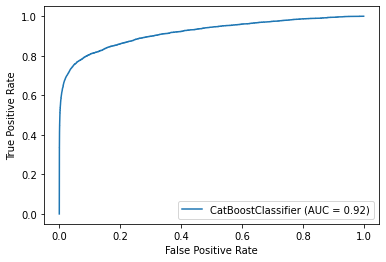

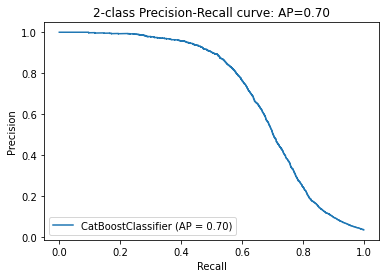

In [22]:
mf.performance(model, X_val, y_val)

[[113378    475]
 [  1869   2385]]


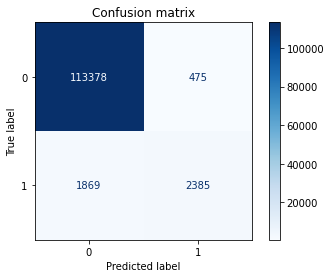

In [23]:
mf.conf_matrix(model, X_val, y_val)

In [24]:
mf.f1(model, X_val, y_val)

0.6705088557773405

Soglia:  0.8
F1 score:  0.63
Recall:  0.49
Precision:  0.89




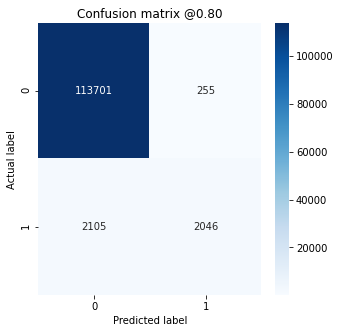



Soglia:  0.7
F1 score:  0.65
Recall:  0.52
Precision:  0.87




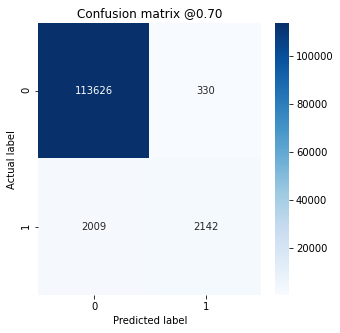



Soglia:  0.6
F1 score:  0.65
Recall:  0.53
Precision:  0.84




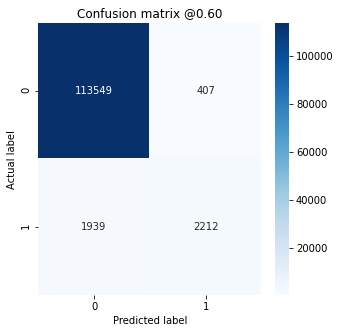



Soglia:  0.5
F1 score:  0.66
Recall:  0.55
Precision:  0.82




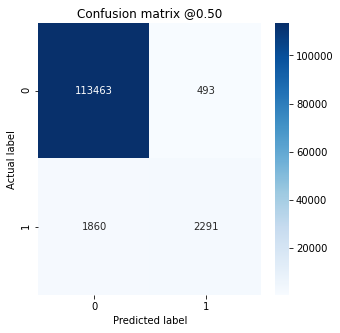



Soglia:  0.2
F1 score:  0.66
Recall:  0.61
Precision:  0.71




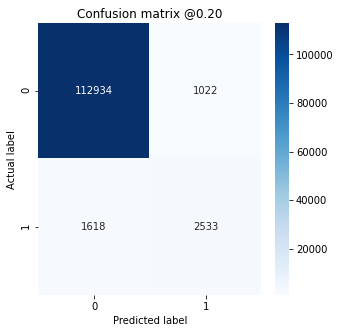



Soglia:  0.1
F1 score:  0.64
Recall:  0.64
Precision:  0.63




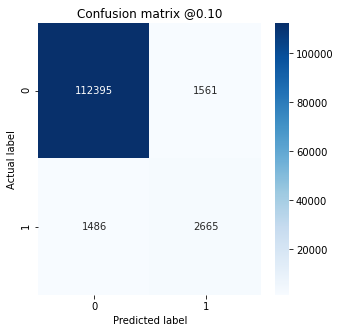



Soglia:  0.05
F1 score:  0.6
Recall:  0.67
Precision:  0.54




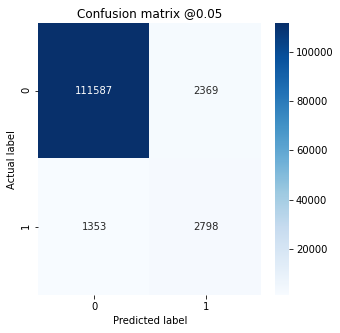



Soglia:  0.02
F1 score:  0.53
Recall:  0.71
Precision:  0.43




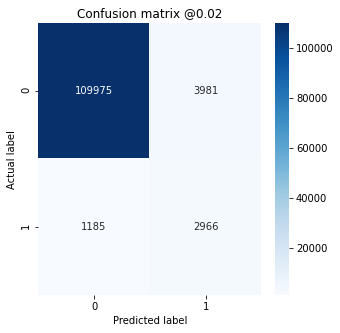



Soglia:  0.01
F1 score:  0.47
Recall:  0.74
Precision:  0.35




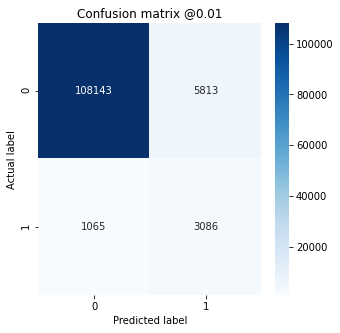



Soglia:  0.005
F1 score:  0.41
Recall:  0.77
Precision:  0.28




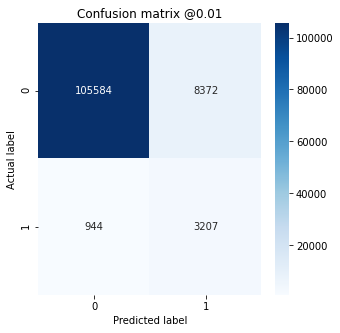



Soglia:  0.002
F1 score:  0.32
Recall:  0.8
Precision:  0.2




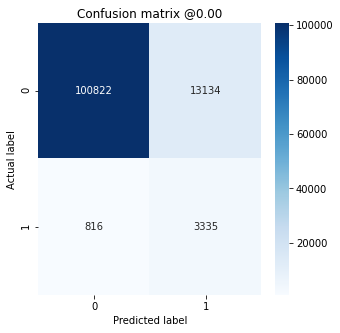

In [26]:
soglie = [0.8, 0.7, 0.6, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002]
proba = model.predict_proba(X_test)
cmap = 'Blues'
precision, recall, f1 = mf.tresh(soglie, proba, y_test, cmap)